# Stan analysis of an LMM with two vector-valued random effects terms

Consider the example

In [1]:
using Compat,DataFrames,MixedModels,Mamba,Stan

bs10 = MixedModels.rdata("bs10");
names(bs10)

Environment variable JULIA_SVG_BROWSER not found.


12-element Array{Symbol,1}:
 :SubjID
 :ItemID
 :Spkr  
 :Filler
 :ms    
 :d     
 :d2    
 :Spkr2 
 :dif   
 :SF    
 :F     
 :S     

The _maximal model_, according to Barr et al. (2012), is 

In [2]:
m0 = fit(lmm(dif ~ 1+S+F+SF + (1+S+F+SF|SubjID) + (1+S+F+SF|ItemID), bs10))

Linear mixed model fit by maximum likelihood
Formula: dif ~ 1 + S + F + SF + ((1 + S + F + SF) | SubjID) + ((1 + S + F + SF) | ItemID)

 logLik: -515.477648, deviance: 1030.955295

 Variance components:
                Variance    Std.Dev.  Corr.
 SubjID         0.013393    0.115730
                0.011216    0.105907  -0.56
                0.003373    0.058075   0.99  0.99
                0.005192    0.072053  -0.13 -0.13 -0.13
 ItemID         0.000305    0.017459
                0.000079    0.008904  -1.00
                0.000136    0.011647   1.00  1.00
                0.000083    0.009125  -1.00 -1.00 -1.00
 Residual       0.127779    0.357462
 Number of obs: 1104; levels of grouping factors: 92, 12

  Fixed-effects parameters:
               Estimate Std.Error  z value
(Intercept)    0.039221 0.0169329  2.31626
S            -0.0174094 0.0156289 -1.11392
F             0.0174819 0.0127947  1.36633
SF           -0.0322645 0.0133832 -2.41082


In [3]:
gc();@time fit(lmm(dif ~ 1+S+F+SF + (1+S+F+SF|SubjID) + (1+S+F+SF|ItemID), bs10));

elapsed time: 3.273203083 seconds (243283104 bytes allocated, 6.62% gc time)


The correlations of the `ItemID` random effects indicate singularity.  (Note that there are only 12 distinct items.)  A check of the λ matrices 

In [4]:
m0.λ

2-element Array{Any,1}:
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.323755    0.0         0.0         0.0
 -0.166342    0.24517     0.0         0.0
  0.161121   -0.0208523   1.28415e-6  0.0
 -0.0265681   0.199809   -1.87098e-6  0.0)    
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.048841    0.0         0.0          0.0
 -0.0249089   9.89284e-7  0.0          0.0
  0.0325814  -7.87822e-8  0.0          0.0
 -0.0255267  -3.65593e-8  5.42382e-10  0.0)

indicates that both are singular.  In a case like this we can zero out the very small values in the parameter vector (these are the elements on and below the diagonal of the λ matrices) without increasing the deviance.

In [5]:
deviance(m0)

1030.9552950545587

In [6]:
MixedModels.objective!(m0,
   Float64[abs(x) < 5e-6 ? 0. : x for x in MixedModels.θ(m0)])

1030.9552950536101

In [7]:
m0.λ

2-element Array{Any,1}:
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.323755    0.0        0.0  0.0
 -0.166342    0.24517    0.0  0.0
  0.161121   -0.0208523  0.0  0.0
 -0.0265681   0.199809   0.0  0.0)
 PDLCholF(Cholesky{Float64} with factor:
4x4 Triangular{Float64,Array{Float64,2},:L,false}:
  0.048841   0.0  0.0  0.0
 -0.0249089  0.0  0.0  0.0
  0.0325814  0.0  0.0  0.0
 -0.0255267  0.0  0.0  0.0)                            

## MCMC for the maximal model using Stan

We define a [Stan](http://mc-stan.org) model similar to that used for `VectorOne`

In [8]:
VectorTwo = """
data {
  int<lower=0>  N; // num observations
  int<lower=1>  K; // length of fixed-effects vector
  int<lower=0>  M; // num subjects
  int<lower=1>  J; // length of subj vector-valued random effects
  int<lower=0>  L; // num items
  int<lower=1>  I; // length of item vector-values random effects
  int<lower=1,upper=M> subj[N]; // subject indicator
  int<lower=1,upper=L> item[N]; // item indicator
  row_vector[K] X[N]; // model matrix for fixed-effects parameters
  row_vector[J] Zs[N]; // generator model matrix for subj random effects
  row_vector[I] Zi[N]; // generator model matrix for item random effects 
  vector[N]     y; // response vector (reaction time)
}

parameters {
  cholesky_factor_corr[J] Ls; // Cholesky factor of subj r.e. correlations
  cholesky_factor_corr[I] Li; // Cholesky factor of item r.e. correlations
  vector<lower=0>[J] taus; // standard deviations of unconditional subj r.e. dist
  vector<lower=0>[I] taui; // standard deviations of unconditional item r.e. dist
  vector[J] us[M];     // spherical subj random effects
  vector[I] ui[L];     // spherical item random effects
  vector[K] beta;      // fixed-effects
  real<lower=0> sigma; // standard deviation of response given random effects
}

transformed parameters {
  matrix[J,J] corrs;
  matrix[I,I] corri;
  corrs <- tcrossprod(Ls);  // for monitoring subj correlations
  corri <- tcrossprod(Li);  // for monitoring item correlations
}

model {
  matrix[J,J] Lambdas; 
  vector[J] bs[M];
  matrix[I,I] Lambdai; 
  vector[I] bi[L];
  taus ~ cauchy(0,2.5);
  taui ~ cauchy(0,2.5);
  Ls ~ lkj_corr_cholesky(2);
  Li ~ lkj_corr_cholesky(2);
  Lambdas <- diag_pre_multiply(taus,Ls);
  Lambdai <- diag_pre_multiply(taui,Li);
  for (m in 1:M) {
    us[m] ~ normal(0,1);
    bs[m] <- Lambdas * us[m];
  }
  for (l in 1:L) {
    ui[l] ~ normal(0,1);
    bi[l] <- Lambdai * ui[l];
  }
  for (n in 1:N)
    y[n] ~ normal(X[n] * beta + Zs[n] * bs[subj[n]] + Zi[n] * bi[item[n]], sigma);
}
""";

In [9]:
X = m0.X.m;
const bs10data = [
    @Compat.Dict("N" => size(X,1),
    "K" => size(X,2),
    "M" => length(bs10[:SubjID].pool),
    "J" => size(X,2),
    "L" => length(bs10[:ItemID].pool),
    "I" => size(X,2),
    "subj" => bs10[:SubjID].refs,
    "item" => bs10[:ItemID].refs,
    "y" => m0.y,
    "X" => X,
    "Zs" => X,
    "Zi" => X)
];

In [10]:
monitor = ["lp__", "accept_stat__","sigma",
    "beta.1","beta.2","beta.3","beta.4",
    "corrs.2.1","corrs.3.1","corrs4.1","corrs.3.2","corrs.4.2","corrs.4.3",
    "taus.1","taus.2","taus.3","taus.4",
    "corri.2.1","corri.3.1","corri4.1","corri.3.2","corri.4.2","corri.4.3",
    "taui.1","taui.2","taui.3","taui.4"];
bs10model = Stanmodel(name="bs10",model=VectorTwo,monitors=monitor,nchains=4);


File /home/juser/notebooks/tmp/bs10.stan will be updated.



In [11]:
gc(); @time sim1 = stan(bs10model, bs10data);



--- Translating Stan model to C++ code ---
bin/stanc /home/juser/notebooks/tmp/bs10.stan --o=/home/juser/notebooks/tmp/bs10.cpp --no_main
Model name=bs10_model
Input file=/home/juser/notebooks/tmp/bs10.stan
Output file=/home/juser/notebooks/tmp/bs10.cpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/eigen_3.2.0 -isystem stan/lib/boost_1.54.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-local-typedefs  -lpthread  -O3 -o /home/juser/notebooks/tmp/bs10 src/cmdstan/main.cpp -include /home/juser/notebooks/tmp/bs10.cpp -Lbin -lstan

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Inference for Stan model: bs10_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (36, 33, 65, 59) seconds, 3.2 minutes total
Sampling took (11, 14, 23, 28) seconds, 1.3 minutes total

                    Mean  

In [12]:
describe(sim1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
26x6 Array{Any,2}:
 ""                  "Mean"    …   "Naive SE"   "MCSE"          "ESS"
 "lp__"           334.385         0.319461     0.581504     2197.48  
 "accept_stat__"    0.898536      0.00173221   0.00192486   3599.65  
 "taus.1"           0.115383      0.000247969  0.000391086  2536.21  
 "taus.2"           0.107018      0.000242296  0.000375553  2580.68  
 "taus.3"           0.0573013  …  0.00023157   0.000310856  2979.77  
 "taus.4"           0.0730334     0.000247313  0.000346334  2856.35  
 "taui.1"           0.0206985     0.000242244  0.000331634  2921.83  
 "taui.2"           0.0148814     0.000188977  0.000252985  2987.97  
 "taui.3"           0.0166884     0.000212522  0.00030607   2777.44  
 "taui.4"           0.017108   …  0.000216569  0.000326989  2649.25  
 "beta.1"           0.038768      0.000273862  0.000330364  3315.88  
 "beta.2"          -0.017

In [13]:
p = plot(sim1,[:trace,:density]);

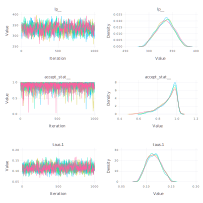

Press ENTER to draw next plot
STDIN> 


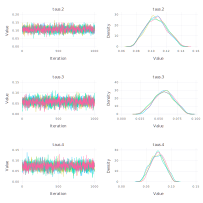

Press ENTER to draw next plot
STDIN> 


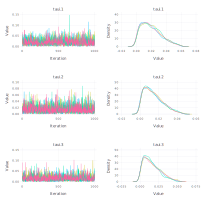

Press ENTER to draw next plot
STDIN> 


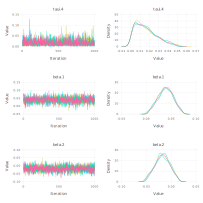

Press ENTER to draw next plot
STDIN> 


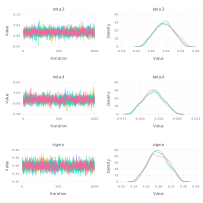

Press ENTER to draw next plot
STDIN> 


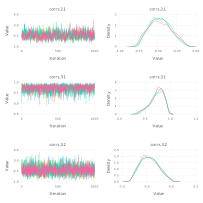

Press ENTER to draw next plot
STDIN> 


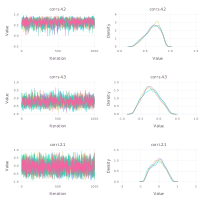

Press ENTER to draw next plot
STDIN> 


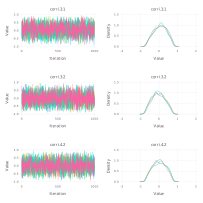

Press ENTER to draw next plot
STDIN> 


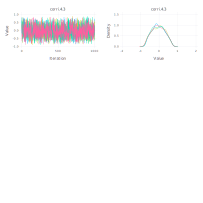

In [14]:
draw(p)

## Data from Kronmueller and Barr (2007)

In [15]:
kb07 = MixedModels.rdata("kb07");
names(kb07)

15-element Array{Symbol,1}:
 :SubjID 
 :ItemID 
 :Spkr   
 :Prec   
 :CogLoad
 :resp   
 :RTPick 
 :RTtrunc
 :S      
 :P      
 :C      
 :SP     
 :SC     
 :PC     
 :SPC    

The _maximal model_ for these data has 72 covariance parameters.

In [16]:
m1 = fit(lmm(RTtrunc ~ 1+S+P+C+SP+SC+PC+SPC + (1+S+P+C+SP+SC+PC+SPC|SubjID) +
(1+S+P+C+SP+SC+PC+SPC|ItemID), kb07))

Linear mixed model fit by maximum likelihood
Formula: RTtrunc ~ 1 + S + P + C + SP + SC + PC + SPC + ((1 + S + P + C + SP + SC + PC + SPC) | SubjID) + ((1 + S + P + C + SP + SC + PC + SPC) | ItemID)

 logLik: -14293.158812, deviance: 28586.317623

 Variance components:
                Variance    Std.Dev.  Corr.
 SubjID       90770.127435  301.280812
              20729.434230  143.977200  -0.43
              22176.516283  148.917817  -0.47 -0.47
              30348.430329  174.208009   0.21  0.21  0.21
              141271.294391  375.860738   0.20  0.20  0.20  0.20
              29142.553713  170.711903   0.47  0.47  0.47  0.47  0.47
              118762.987278  344.620062  -0.10 -0.10 -0.10 -0.10 -0.10 -0.10
              243330.196304  493.285107  -0.48 -0.48 -0.48 -0.48 -0.48 -0.48 -0.48
 ItemID       129824.455072  360.311608
              7421.712583   86.149362  -0.34
              249572.333357  499.572150  -0.68 -0.68
              11792.047965  108.591197   0.20  0.20  0.20


As in the initial fit of `m0`, several of the values in `m1.λ` are close to zero and may be zeroed out.

In [17]:
m1.λ

2-element Array{Any,1}:
 PDLCholF(Cholesky{Float64} with factor:
8x8 Triangular{Float64,Array{Float64,2},:L,false}:
  0.476598    0.0         0.0        …   0.0           0.0           0.0
 -0.0989306   0.20515     0.0            0.0           0.0           0.0
 -0.111555   -0.0341984   0.204649       0.0           0.0           0.0
  0.0590247  -0.0332027   0.156033       0.0           0.0           0.0
  0.116589   -0.443694   -0.377605       0.0           0.0           0.0
  0.127792   -0.0974204   0.0203139  …   1.78746e-51   0.0           0.0
 -0.0556916   0.050633   -0.0536061      1.59785e-51   3.40508e-141  0.0
 -0.371102    0.174336   -0.520432      -3.19233e-51  -9.07154e-141  0.0)
 PDLCholF(Cholesky{Float64} with factor:
8x8 Triangular{Float64,Array{Float64,2},:L,false}:
  0.569979    0.0          0.0        …   0.0          0.0           0.0
 -0.0467809   0.127999     0.0            0.0          0.0           0.0
 -0.534094   -0.576117     0.08584        0.0          0.0   

In [18]:
MixedModels.objective!(m1,Float64[abs(x) < 5e-6 ? 0. : x for x in MixedModels.θ(m1)])

28586.31762314728

In [19]:
map(svdvals,m1.λ)

2-element Array{Any,1}:
 [0.894115,0.667186,0.60064,0.37104,0.0,0.0,0.0,0.0]           
 [1.01248,0.818828,0.474259,0.340798,0.16643,6.4107e-6,0.0,0.0]

## MCMC samples from model `m1`

We can use the same Stan model as for the `bs10` data and model `m0` changing only the data and the parameters to be monitored.

In [21]:
X = m1.X.m;
const kb07data = [
    @compat(Dict("N" => size(X,1),
        "K" => size(X,2),
        "M" => length(kb07[:SubjID].pool),
        "J" => size(X,2),
        "L" => length(kb07[:ItemID].pool),
        "I" => size(X,2),
        "subj" => kb07[:SubjID].refs,
        "item" => kb07[:ItemID].refs,
        "y" => m1.y,
        "X" => X,
        "Zs" => X,
        "Zi" => X))
];

In [23]:
monitor = ["lp__", "accept_stat__","sigma",
    "beta.1","beta.2","beta.3","beta.4","beta.5","beta.6","beta.7","beta.8",
    "corrs.2.1","corrs.3.1","corrs.4.1","corrs.5.1","corrs.6.1","corrs.7.1","corrs.8.1",
    "corrs.3.2","corrs.4.2","corrs.5.2","corrs.6.2","corrs.7.2","corrs.8.2",
    "corrs.4.3","corrs.5.3","corrs.6.3","corrs.7.3","corrs.8.3",
    "corrs.5.4","corrs.6.4","corrs.7.4","corrs.8.4",
    "corrs.6.5","corrs.7.5","corrs.8.5",
    "corrs.7.6","corrs.8.6",
    "corrs.8.7",
    "taus.1","taus.2","taus.3","taus.4","taus.5","taus.6","taus.7","taus.8",
    "corri.2.1","corri.3.1","corri.4.1","corri.5.1","corri.6.1","corri.7.1","corri.8.1",
    "corri.3.2","corri.4.2","corri.5.2","corri.6.2","corri.7.2","corri.8.2",
    "corri.4.3","corri.5.3","corri.6.3","corri.7.3","corri.8.3",
    "corri.5.4","corri.6.4","corri.7.4","corri.8.4",
    "corri.6.5","corri.7.5","corri.8.5",
    "corri.7.6","corri.8.6",
    "corri.8.7",
    "taui.1","taui.2","taui.3","taui.4","taui.5","taui.6","taui.7","taui.8"];
kb07model = Stanmodel(name="kb07",model=VectorTwo,monitors=monitor,nchains=4);


File /home/juser/notebooks/tmp/kb07.stan will be updated.



In [ ]:
gc(); @time sim2 = stan(kb07model, kb07data);



--- Translating Stan model to C++ code ---
bin/stanc /home/juser/notebooks/tmp/kb07.stan --o=/home/juser/notebooks/tmp/kb07.cpp --no_main
Model name=kb07_model
Input file=/home/juser/notebooks/tmp/kb07.stan
Output file=/home/juser/notebooks/tmp/kb07.cpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/eigen_3.2.0 -isystem stan/lib/boost_1.54.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-local-typedefs  -lpthread  -O3 -o /home/juser/notebooks/tmp/kb07 src/cmdstan/main.cpp -include /home/juser/notebooks/tmp/kb07.cpp -Lbin -lstan

Length of data array is not equal to nchains,
all chains will use the first data dictionary.



This seems to hang, even though the Stan runs succeed.